In [1]:
import os

import numpy as np
from scipy.optimize import fsolve

from migdalcalc import migdalcalc as mc
from migdalcalc.migdal import quench
from migdalcalc.migdal import ionization as ion
from migdalcalc.migdal import kinematics as kin

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from plots import interp_csv
plt.rcParams['figure.dpi'] = 100
plt.rcParams['text.usetex'] = False

In [2]:
Si_migdal = mc.migdalcalc(target="Si-28", nuclear_data_name="jeff33")

In [3]:
Angles = [10, 72]
Energies = [2*1e3, 23*1e3, 54*1e3, 2507*1e3]

YL = lambda E: quench.Lindhard_Factor(E, 14, 28)
YS = lambda E: quench.Y_Si_sarkis(E)

print(fsolve(lambda E: YL(E)*E - 240, 2000))
print(fsolve(lambda E: YS(E)*E - 240, 2000))

[1125.13993508]
[1646.07432011]


1.7071614819547574


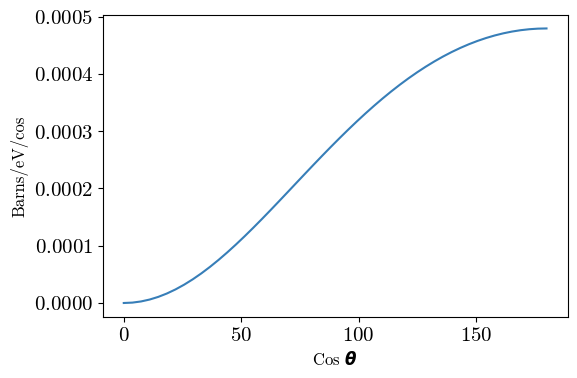

In [4]:
A = Si_migdal.A
m_n = 0.939*1e9 #m_n in eV
N_per_g = (6.02e23/A)
barns_to_cm2 = 1e-24
flux = 1e3 #nuetrons/cm^2/second
seconds_to_days = 60*60*24 #seconds to days
phi_int = 2*np.pi #integral over phi
thickness = 1 #1 cm
density =  4.99e22 #per cubic cm

xsec_to_events_per_nuetron = density*thickness*barns_to_cm2*phi_int
xsec_to_inv_gram_days = flux*N_per_g*barns_to_cm2*seconds_to_days*phi_int

flux_factor=xsec_to_events_per_nuetron

print(Si_migdal.nuc.SIG(23000))


cross_section_lab = Si_migdal.d2R_dc_dDeltaE(En=23000, method="gpaw_withLFE")

c_range = np.linspace(-1, 1)
angles = np.linspace(0, 180)
plt.plot(angles, cross_section_lab(10, np.cos(np.pi*angles/180)))
plt.xlabel(r"Cos $\theta$")
plt.ylabel("Barns/eV/cos")
plt.show()




Er = 2.1691647501017357
q_N = 337732.6741956568
0.0
0.09112238497065375


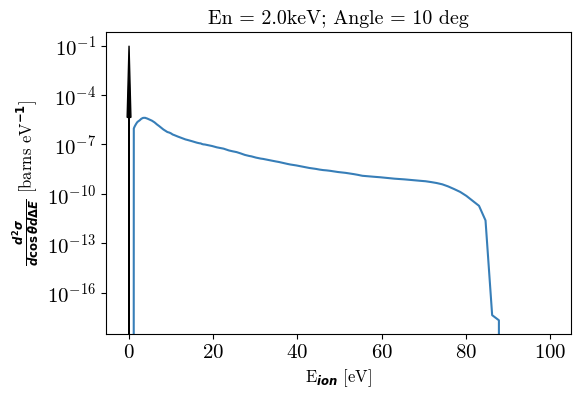

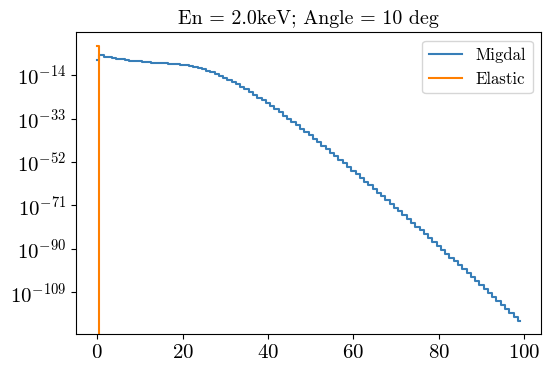

Er = 96.34732612741898
q_N = 2250850.460844567
0.0
0.1522936764557554


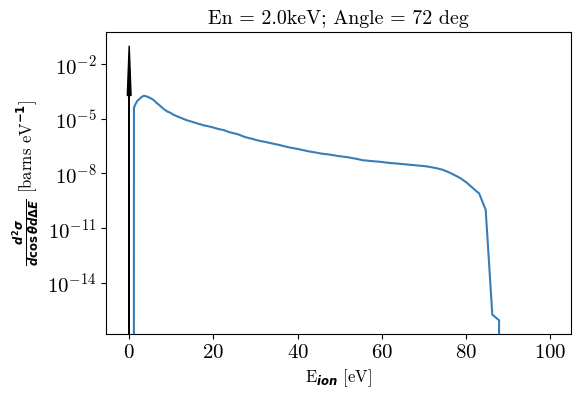

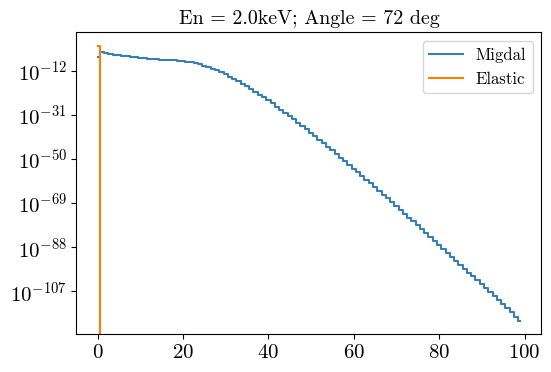

Er = 24.94539462616996
q_N = 1145307.2212391405
0.0
0.12701644728790512


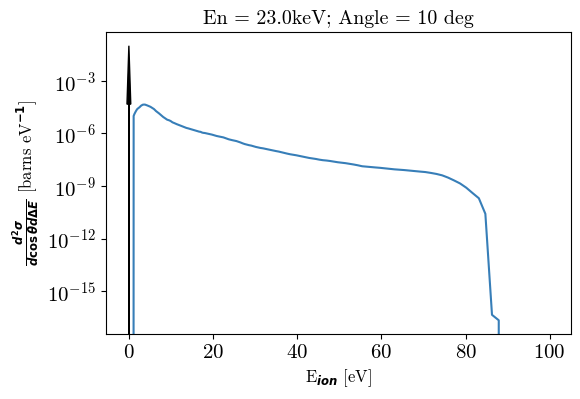

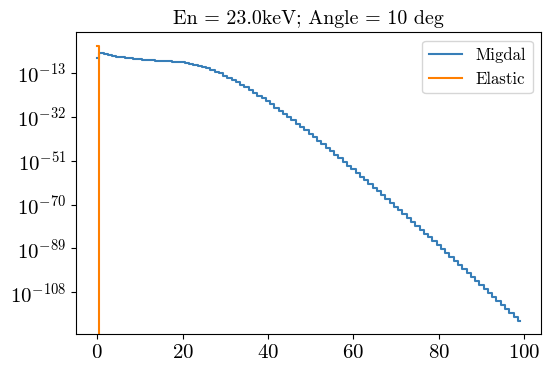

Er = 1107.9942504653181
q_N = 7633005.284058716
0.11880515479643002
0.21283822777409875


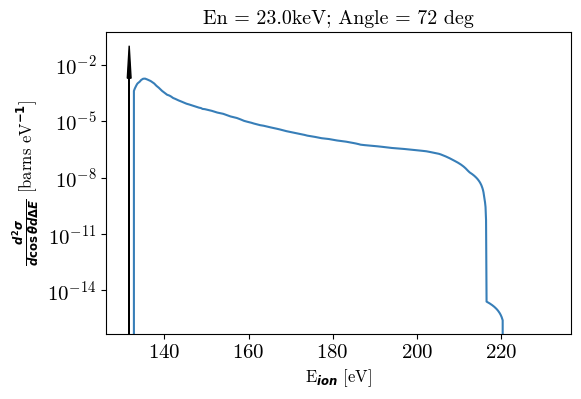

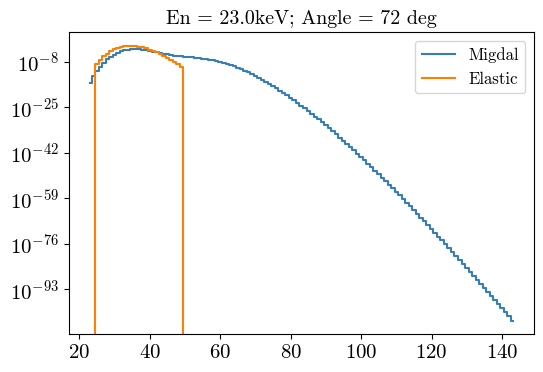

Er = 58.56744825274686
q_N = 1754910.4532489516
0.0
0.14245191816824132


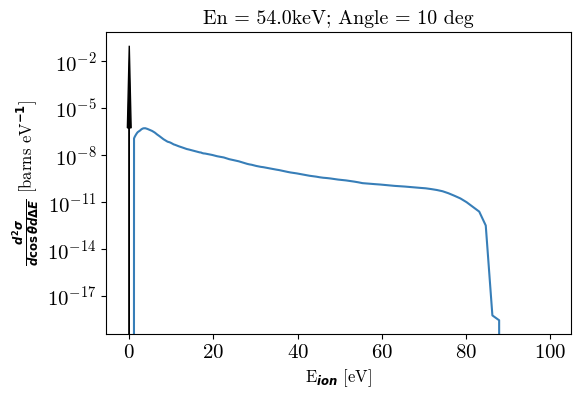

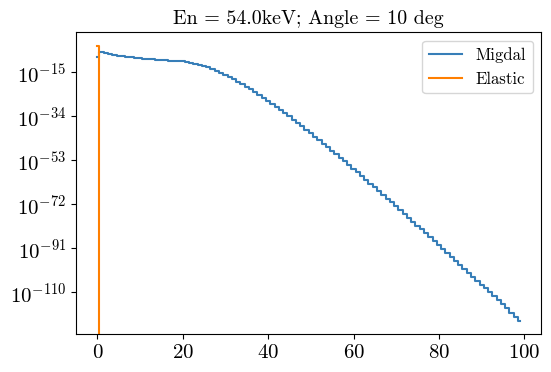

Er = 2601.3778054403124
q_N = 11695762.075267836
0.17724415767808757
0.2414534785320885


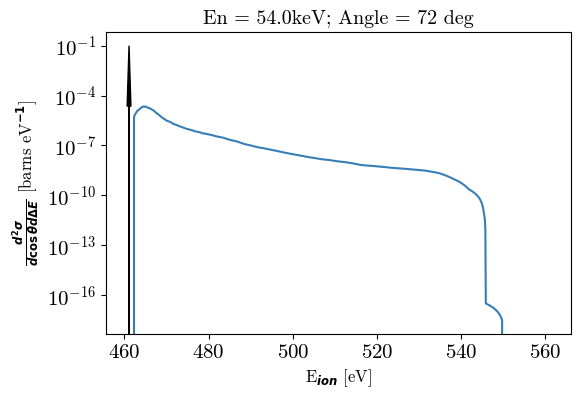

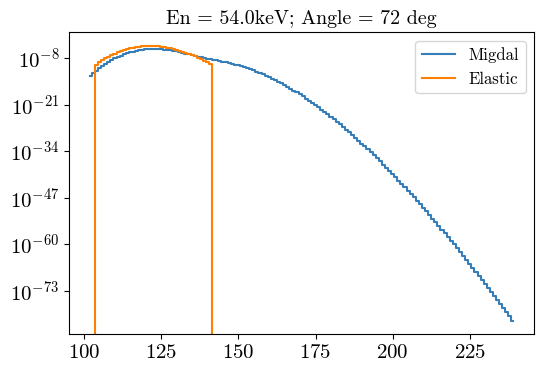

Er = 2719.0480142525253
q_N = 11957358.43660525
0.1805307871289693
0.24310189802535667


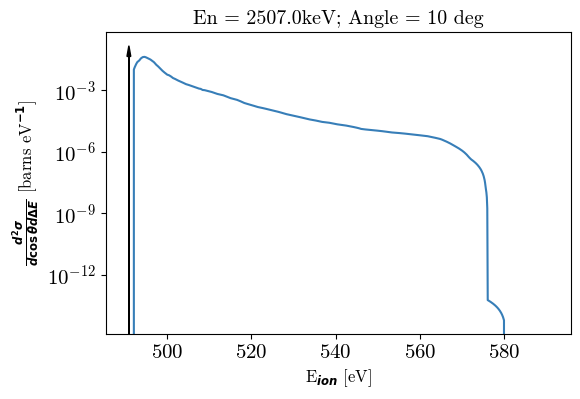

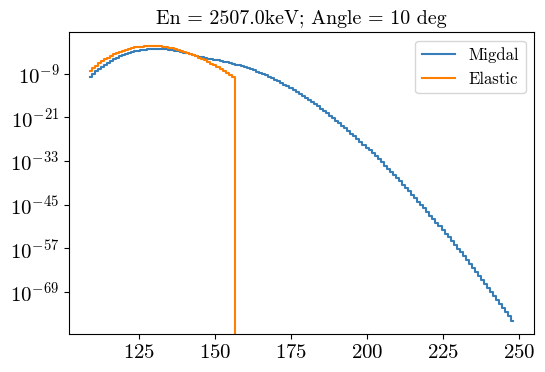

Er = 120771.37330071967
q_N = 79690914.74970683
0.5325728475582832
0.5325728475582832


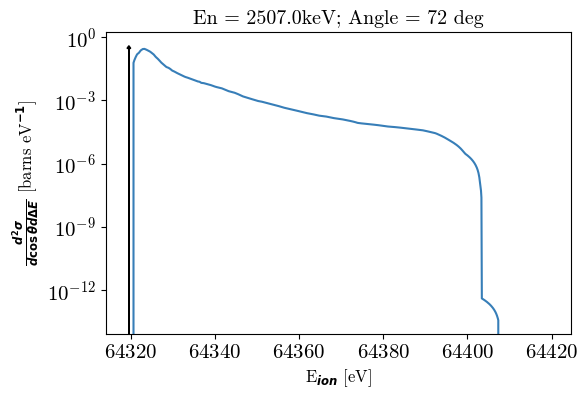

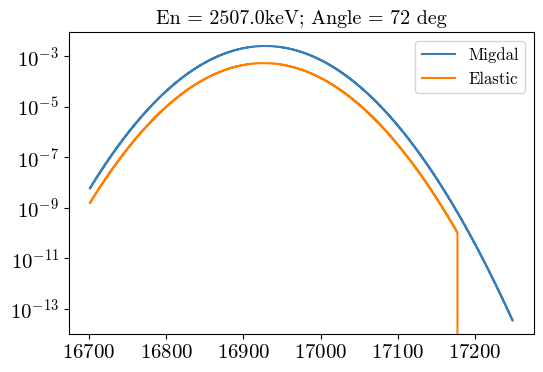

In [5]:
method = "gpaw_withLFE"

for En in Energies:
    elastic_spectrum = Si_migdal.nuc.dSig_dOmega(En)
    
    for angle in Angles:
        save_folder = './output/' + str(int(1e-3*En)) + 'keV/' + str(angle) + 'deg/' 
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
            
        c = np.cos(angle*np.pi/180)
        
        Si_ion_spec_sarkis = Si_migdal.dR_dEion(c, En, YS, method)
        Si_ion_spec_lind   = Si_migdal.dR_dEion(c, En, YL, method)
        
        print("Er = " + str(kin.E_Recoil(0, c, A, En)))
        print("q_N = " + str(np.sqrt(2*A*m_n*kin.E_Recoil(0, c, A, En))))
        
        
        ER_Q_sarkis = kin.E_Recoil(0, c, A, En)*YS(kin.E_Recoil(0, c, A, En))
        ER_Q_lind   = kin.E_Recoil(0, c, A, En)*YL(kin.E_Recoil(0, c, A, En))
        
        print(YS(kin.E_Recoil(0, c, A, En)))
        print(YL(kin.E_Recoil(0, c, A, En)))
        
        elastic_rate = flux_factor*elastic_spectrum(c)
        
        #Plot the ionization spectrum
        E_ion_range = np.geomspace(ER_Q_sarkis + 1e-6, ER_Q_sarkis + 100, 1000)
        plt.plot(E_ion_range, Si_ion_spec_sarkis(E_ion_range))
        xmin, xmax, ymin, ymax = plt.axis()
        
        plt.arrow(ER_Q_sarkis, ymin, 0, ymax -ymin, head_width=0.9, head_length=1e-1,fc='black')
        plt.yscale('log')
        
        plt.ylabel(r'$\frac{d^2 \sigma}{d \cos \theta d \Delta E}$ [barns eV$^{-1}$]')
        plt.xlabel(r'E$_{ion}$ [eV]')
        plt.title("En = " + str(1e-3*En) + "keV; Angle = " + str(angle) + " deg")
        plt.savefig(save_folder + 'E_ion.png')
        plt.show()
        
        #Estimate the first and last electron bins we need to consider
        fano = 0.119 #fano factor
        eps  = 3.8 #energy per eh pair
        n_base_sarkis = np.floor(ER_Q_sarkis/eps)
        n_base_lind   = np.floor(ER_Q_lind/eps)
        
        first_n_sarkis = max(np.floor(ER_Q_sarkis/eps) - 5*np.sqrt(fano*n_base_sarkis), 0)
        first_n_lind   = max(np.floor(ER_Q_lind/eps)   - 5*np.sqrt(fano*n_base_lind), 0)
        
        final_n_sarkis = np.floor(ER_Q_sarkis/eps) + 5*np.sqrt(fano*n_base_sarkis) + 100
        final_n_lind   = np.floor(ER_Q_lind/eps)   + 5*np.sqrt(fano*n_base_lind) + 100
        
        n_bins_sarkis = final_n_sarkis - first_n_sarkis
        n_bins_lind   = final_n_lind   - first_n_lind
        
        n_sarkis, r_sarkis = ion.Si_electron_spectrum(Si_ion_spec_sarkis, ER_Q_sarkis, \
                                                      start_bin=first_n_sarkis, number_of_bins=n_bins_sarkis,flux=flux_factor)
        n_lind, r_lind     = ion.Si_electron_spectrum(Si_ion_spec_lind, ER_Q_lind, \
                                                      start_bin=first_n_lind, number_of_bins=n_bins_lind,flux=flux_factor)
        
        n_el_sarkis, r_el_sarkis = ion.Si_elastic_electron_spectrum_fixed_angle(ER_Q_sarkis, elastic_rate, \
                                                                               start_bin=first_n_sarkis, number_of_bins=n_bins_sarkis)
        n_el_lind, r_el_lind     = ion.Si_elastic_electron_spectrum_fixed_angle(ER_Q_lind, elastic_rate, \
                                                                               start_bin=first_n_lind, number_of_bins=n_bins_lind)
        
        plt.step(n_sarkis, r_sarkis, where='mid',label='Migdal')
        plt.step(n_el_sarkis, r_el_sarkis, where='mid',label='Elastic')
        plt.title("En = " + str(1e-3*En) + "keV; Angle = " + str(angle) + " deg")
        plt.legend()
        plt.yscale('log')

        
        plt.show()
        
        np.savetxt(save_folder + method + '_Ne_sarkis_migdal.csv', list(zip(n_sarkis, r_sarkis)), \
                   delimiter=',', fmt='%.5e', header='bin number, rate')
                   
        np.savetxt(save_folder + method + '_Ne_sarkis_elastic.csv', list(zip(n_el_sarkis, r_el_sarkis)), \
                   delimiter=',', fmt='%.5e', header='bin number, rate')
        
        np.savetxt(save_folder + method +'_Ne_lindhard_migdal.csv', list(zip(n_lind, r_lind)), \
                   delimiter=',', fmt='%.5e', header='bin number, rate')
                   
        np.savetxt(save_folder + method +'_Ne_lindhard_elastic.csv', list(zip(n_el_lind, r_el_lind)), \
                   delimiter=',', fmt='%.5e', header='bin number, rate')
